In [3]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
import tensorflow as tf
import cv2
import imageio
import pandas as pd
import numpy as np
from helpers_trans import Fy, find_closest_element
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
density_path = '../../data/commaai/density/gaussian_density_filtered.csv'
density = pd.read_csv(density_path)

In [93]:
class DensityPredictor:
    
    def __init__(self, method, model, p):
        ''' initialize trained model
        choice of:
        - precise learner: 'precise'
        - imprecise learner: 'imprecise'
        Parameters
        ----------
        p: int
            number of coefficients of last hidden layer
        '''
        self.model = model
        self.method = method
        self.p = p
        
        if self.model == 'precise':
            self.extracted_coefficients_path_beta_dnn = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'
            self.extracted_coefficients_path_beta_hmc = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'
            self.extracted_coefficients_path_beta_va = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'
        if self.model == 'imprecise':
            self.extracted_coefficients_path_beta = '../../data/commaai/extracted_coefficients/20201021_unrestr_gaussian_resampled/beta/'
            self.extracted_coefficients_path_beta_hmc = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'
            self.extracted_coefficients_path_beta_va = '../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/beta/'
    
    def load_bzeta_model(self):
        
        print('building model ...')
        Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
        x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
        x = BatchNormalization()(x)
        x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
        #x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(1164)(x)
        x = Dropout(0.5)(x)
        x = Dense(100)(x)
        x = Dropout(0.5)(x)
        x = Dense(50)(x) 
        x = Dropout(0.2)(x)
        x = Dense(10)(x)

        B_zeta_model = tf.keras.models.Model(
              inputs = [Input], outputs = [x])
        # keras model for basis functions B_zeta
        
        print('loading model weights ...')
        if self.model == 'precise':
            checkpoint_path = '../../data/models/20201027_filtered_gaussian_resampled/'
            B_zeta_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)
            self.Bzetamodel = B_zeta_model
            print('... finished loading weights.')
            
        elif self.model == 'imprecise':
            checkpoint_path = '../../data/models/20201021_unrestr_gaussian_resampled/'
            B_zeta_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)
            self.Bzetamodel = B_zeta_model
            print('... finished loading weights.')
        else:
            return('unknown model type')
    
    def load_z_model(self):
        
        # define model and load weights from training
        Input = tf.keras.layers.Input(shape=(66, 200, 3,), name='image')
        x = Conv2D(24, kernel_size=(5, 5), activation='relu', strides=(2, 2))(Input)
        x = BatchNormalization()(x)
        x = Conv2D(36, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(48, kernel_size=(5, 5), activation='relu', strides=(2, 2))(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
        #x = BatchNormalization()(x)
        x = Flatten()(x)
        x = Dropout(0.5)(x)
        x = Dense(1164)(x)
        x = Dropout(0.5)(x)
        x = Dense(100)(x)
        x = Dropout(0.5)(x)
        x = Dense(50)(x) 
        x = Dropout(0.2)(x)
        x = Dense(10)(x)
        Output = Dense(1, name = 'output_layer')(x)

        z_model = tf.keras.models.Model(
              inputs = [Input], outputs = [Output])
        
        print('loading model weights ...')
        if self.model == 'precise':
            checkpoint_path = '../../data/models/20201027_filtered_gaussian_resampled/'
            z_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)
            self.z_model = z_model
            print('... finished loading weights.')
            
        elif self.model == 'imprecise':
            checkpoint_path = '../../data/models/20201021_unrestr_gaussian_resampled/'
            z_model.load_weights(tf.train.latest_checkpoint(checkpoint_path)) # tf.train.latest_checkpoint(checkpoint_path)
            self.z_model = z_model
            print('... finished loading weights.')
        else:
            return('unknown model type')
    
    def predict_z(self, image_path_list):
        
        print('start predicting z on images ...')
        z_preds = []
        images = []
        
        for img_path in image_path_list:
            # load image
            img = imageio.imread(img_path)
            images.append(img)
            img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3].reshape(1,66,200,3)/255
            # predict Bzeta
            z_pred = self.z_model.predict(img)
            z_preds.append(z_pred)
        
        print('... finished predicting z on images.')
        self.z_pred = np.array(z_preds).reshape(len(image_path_list),)
        self.images = images
        return(self.z_pred)
        
        
    
    def predict_Bzeta(self, image_path_list, ifpath, single_img):
        
        print('start predicting Bzeta on images ...')
        B_zetas = []
        images = []
        
        if ifpath:
            for img_path in image_path_list:
                # load image
                img = imageio.imread(img_path)
                images.append(img)
                img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3].reshape(1,66,200,3)/255
                # predict Bzeta
                B_zeta = self.Bzetamodel.predict(img)
                B_zetas.append(B_zeta)
        
        else:
            B_zeta = self.Bzetamodel.predict(single_img)
            B_zetas.append(B_zeta)
            
        
        print('... finished predicting Bzeta on images.')
        self.B_zetas = np.array(B_zetas).reshape(len(image_path_list), self.p)
        self.images = images
    
    def choose_method(self, method):
        '''choose desired estimation method, choice of:
            - normal DNN: 'dnn'
            - Ridge prior & HMC: 'hmc_ridge'
            - Ridge prior & VA: 'va_ridge
            - Horseshoe prior & HMC: 'hmc_horseshoe'
            - Horseshoe prior & VA: 'va_horseshoe'
            '''
        
        self.method = method
        if method == 'dnn':
            beta = np.genfromtxt(str(self.extracted_coefficients_path_beta + 'beta.csv'), delimiter = ',')
        
        elif method == 'hmc_ridge':
            pass
        
        elif (method == 'va_ridge') & (self.model == 'precise'):
            va_ridge_dir = '../../data/commaai/va/filtered_gaussian_resampled/Ridge/'
            self.mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
            self.iter = self.mu_t_va.shape[0]
            self.beta = np.mean(self.mu_t_va[int(0.9*self.iter):self.iter,0:10], axis = 0)
            self.tau_sq = np.exp(np.mean(self.mu_t_va[int(0.9*self.iter):self.iter,10], axis = 0))
            print('chose variational approximation with ridge prior as method')
        
        elif (method == 'va_ridge') & (self.model == 'imprecise'):
            va_ridge_dir = '../../data/commaai/va/unfiltered_gaussian_resampled/Ridge/'
            self.mu_t_va = np.genfromtxt(va_ridge_dir + 'mu_t_va.csv', delimiter = ',')
            self.beta =  self.mu_t_va[0:10] #np.mean(self.mu_t_va[int(0.9*50000):50000,0:10], axis = 0)
            self.tau_sq = np.exp(self.mu_t_va[10]) #np.exp(np.mean(self.mu_t_va[int(0.9*50000):50000,10], axis = 0))
            print('chose variational approximation with ridge prior as method')
        
        elif (method == 'va_horseshoe') & (self.model == 'precise'):
            self.va_horseshoe_dir = '../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/'
            self.mu_t_va = np.load(self.va_horseshoe_dir + 'mu_ts2.npy')
            self.iteration = self.mu_t_va.shape[0]
            self.p = 10
            self.B_ts = np.mean(np.load(self.va_horseshoe_dir + 'B_ts2.npy')[int(0.9*self.iteration):,:,:], axis = 0)
            self.d_ts = np.mean(np.load(self.va_horseshoe_dir + 'd_ts2.npy')[int(0.9*self.iteration):,:,:], axis = 0)
            self.var = np.sqrt(np.diag(self.B_ts.dot(self.B_ts.T) + self.d_ts**2))
            self.beta = np.mean(self.mu_t_va[int(0.9*self.iteration):,0:10], axis = 0)
            self.Lambdas_log = np.mean(self.mu_t_va[int(0.9*self.iteration):,10:20], axis = 0)
            self.samples = np.exp(0.5*np.random.multivariate_normal(self.Lambdas_log.reshape(10,), np.diag(self.var[10:20]), 10000))
            self.Lambda = np.mean(self.samples, axis = 0)
            #self.beta = self.mu_t_va[0:10]
            #self.Lambda = np.exp(0.5*self.mu_t_va[10:20])
            #self.tau = np.exp(self.mu_t_va[20])
            print('chose variational approximation with ridge prior as method')
    
    def initialize_grid(self, density, no_points):
        
        print('computing fixed values for density estimation ...')
        self.grid = np.linspace(min(density['axes']), max(density['axes']), no_points)
        density_y = density['axes']
        density_pdf = density['pdf']
        # compute these beforehand to save computation time
        self.p_y_y0 = [density_pdf[find_closest_element(y_i,density_y)] for y_i in self.grid]
        self.part_1 = np.array([norm.ppf(Fy(y_i, density)) for y_i in self.grid])
        self.phi_1_z = np.array([scipy.stats.norm(0, 1).pdf(y_i) for y_i in self.part_1 ])
        print('...finished computing fixed values.')
        
    def predict_density(self):
        
        def predict_single_density(x, grid, p_y_y0, part_1, phi_1_z, beta, tau_sq, Lambda, method):
    
            psi_x0 = x

            f_eta_x0 = psi_x0.dot(beta)
            
            if method == 'va_ridge' or method == 'hmc_ridge':
                s_0_hat = (1 + tau_sq*psi_x0.dot(psi_x0))**(-0.5)
            
            elif method == 'va_horseshoe' or method == 'hmc_horseshoe':
                s_0_hat = (1 + (psi_x0*(Lambda**2)).dot(psi_x0))**(-0.5)

            part_0 = s_0_hat*f_eta_x0
            
            # compute the cdf of new ys
            term_1 = scipy.stats.norm(0, 1).pdf((part_1 - part_0) / s_0_hat)
            p_y_single_obs_whole_dens = (p_y_y0/phi_1_z)*(1/s_0_hat)*term_1

            return(p_y_single_obs_whole_dens)
        
        if self.method == 'va_ridge':
            self.Lambda = np.zeros(1)
            self.densities = [predict_single_density(self.B_zetas[i,:], self.grid, self.p_y_y0, self.part_1, self.phi_1_z, self.beta, self.tau_sq, self.Lambda, self.method) for i in range(0,self.B_zetas.shape[0])]
            #densities = np.array(densities).reshape(self.B_zetas.shape[0], len(self.grid))
        if self.method == 'va_horseshoe':
            self.tau_sq = np.zeros(1)
            self.densities = [predict_single_density(self.B_zetas[i,:], self.grid, self.p_y_y0, self.part_1, self.phi_1_z, self.beta, self.tau_sq, self.Lambda, self.method) for i in range(0,self.B_zetas.shape[0])]
            
        return(self.densities)
    
    def show_predictive_density(self, image_number, label, pred):
        
        ang_dens = pd.DataFrame({'angle': np.linspace(-50,50,1000), 'density': self.densities[image_number]})
        max_dens = max(ang_dens['density'])
        const = 1/max_dens
        def plot_density(ang_dens, c, r):
            ang_dens['angle_rad'] = ang_dens['angle'].apply(lambda x: x / 180. * np.pi + np.pi / 2)
            ang_dens['t'] = ang_dens['angle_rad'].apply(lambda x: (c[0] + np.cos(x) * r, c[1] - np.sin(x) * r))
            for i in range(0, ang_dens['t'].shape[0]):
                t = ang_dens['t'][i]
                dens = max(0,ang_dens['density'][i]*const)
                plt.plot((c[0], t[0]), (c[1], t[1]), 'dodgerblue', alpha = dens)

        figure, ax = plt.figure(), plt.gca()
        ax.imshow(self.images[image_number][:,:,0:3].astype(int))
        a_rad = label / 180. * np.pi + np.pi / 2
        c, r = (582,873), 300 #center, radius
        plot_density(ang_dens, c, r)
        t = (c[0] + int(np.cos(a_rad) * r), c[1] - int(np.sin(a_rad) * r))
        plt.plot((c[0], t[0]), (c[1], t[1] + 30), 'w', alpha = 1)
        a_rad = pred / 180. * np.pi + np.pi / 2
        c, r = (582,873), 300 #center, radius
        t = (c[0] + int(np.cos(a_rad) * r), c[1] - int(np.sin(a_rad) * r))
        plt.plot((c[0], t[0]), (c[1] , t[1] + 30), 'r', alpha = 1)
        plt.gca().add_artist(plt.Circle(c, r, edgecolor='dodgerblue', facecolor='k'))
        plt.text(c[0] - 550 , c[1] - 800, 'steering angle'.format(label), color='w')
        plt.text(c[0] - 550 , c[1] - 750, 'true: {:0.1f}$^\circ$'.format(label), color='w')
        plt.text(c[0] - 550 , c[1] - 700, 'predicted: {:0.1f}$^\circ$'.format(pred), color='r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        figure.savefig('example_steering_visualization.pdf', format='pdf', dpi=900)
    
    
    def confidence_interval(self, density, confidence_level, z_preds):
        
        confidence_intervals = []
        j = 0
        for z_pred in z_preds:
            pred_y = density.loc[find_closest_element(norm.cdf(z_pred), density['cdf']), 'axes']

            integrals = []

            for i in range(0, len(densities[0]) - 1):
                integral = integrate.simps([max(0,self.densities[0][i]),max(0,self.densities[0][i + 1])], [self.grid[i], self.grid[i+1]])
                integrals.append(integral)
                
            int_sum = 0
            i = 1
            start_index = np.searchsorted(density['axes'], pred_y)
            while int_sum < confidence_level:
                int_sum += integrals[start_index - i] + integrals[start_index + i]
                i += 1
            confidence_intervals.append([density.loc[start_index - i,'axes'], density.loc[start_index + i,'axes']])
        return(confidence_intervals)

    

In [81]:
path_all_imgs = '../../data/commaai/training_files_filtered/indices/train_indices.csv'
all_img_df = pd.read_csv(path_all_imgs)
img_path_base = '../../data/commaai/train_bags_2/'
paths = img_path_base + all_img_df['path'][0:5]

In [98]:
all_img_df.loc[all_img_df['path'] == '0/121_254run1.png']

,id,path,use,angle,filenumber
21955,138885,0/121_254run1.png,1.0,-1.5,254


In [83]:
paths = [ '../../Parting_of_the_ways_-_geograph.org.uk_-_1325256.jpg',
         '../../road-markings-madness.png',
         '../../mountain-road-curve-to-right-fagaras-mountains-alpine-highway-43754624.jpg',
         '../../data/commaai/train_bags_2/1/15_1241run1.png', # no lane markings
         '../../data/commaai/train_bags_2/2/25_1293run1.png', # confusing lane markings
         '../../data/commaai/train_bags_2/1/69_340run1.png', # clear lane markings
         '../../data/commaai/train_bags_2/0/28_911run1.png', # stop & go traffic
         '../../data/commaai/train_bags_2/0/149_912run1.png', # parting road
         '../../data/commaai/train_bags_2/0/76_921run1.png', # bad lighting
         '../../data/commaai/train_bags_2/0/15_947run1.png', # parting road
         '../../data/commaai/train_bags_2/0/24_1000run1.png', # parting road
         '../../data/commaai/train_bags_2/0/118_977run1.png', # left turn only half visible
         '../../data/commaai/train_bags_2/0/80_436run1.png', # parting road, closer
         '../../data/commaai/train_bags_2/0/121_254run1.png', # parting road, closer, other side
         '../../data/commaai/train_bags_2/0/202_429run1.png', # bad view, 
         '../../data/commaai/train_bags_2/0/4_500run1.png' #parting road
        ]

In [114]:
paths[12]

'../../data/commaai/train_bags_2/0/80_436run1.png'

In [9]:
predictor_va_prec = DensityPredictor('va_ridge', 'precise', 10)
predictor_va_prec.load_bzeta_model()
predictor_va_prec.predict_Bzeta(paths, True, False)
predictor_va_prec.choose_method('va_ridge')
predictor_va_prec.initialize_grid(density, 65536)
densities_va_prec = predictor_va_prec.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


In [94]:
predictor_va_prec_horse = DensityPredictor('va_horseshoe', 'precise', 10)
predictor_va_prec_horse.load_bzeta_model()
predictor_va_prec_horse.predict_Bzeta(paths, True, False)
predictor_va_prec_horse.choose_method('va_horseshoe')
predictor_va_prec_horse.initialize_grid(density, 65536)
densities_va_prec_horse = predictor_va_prec_horse.predict_density()

building model ...
loading model weights ...
... finished loading weights.
start predicting Bzeta on images ...
... finished predicting Bzeta on images.
chose variational approximation with ridge prior as method
computing fixed values for density estimation ...
...finished computing fixed values.


No handles with labels found to put in legend.


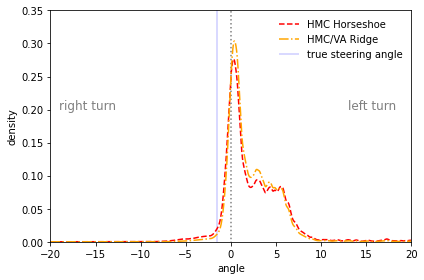

In [123]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[13], color = 'red', linestyle= '--', label = 'HMC Horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[13], color = 'orange', label = 'HMC/VA Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
ax.legend()
plt.tight_layout()
plt.vlines(x = -1.5, ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.legend(framealpha=0.0)
plt.savefig('../../data/commaai/calibration/examples_viz/dens_121_254run1.png') 

No handles with labels found to put in legend.


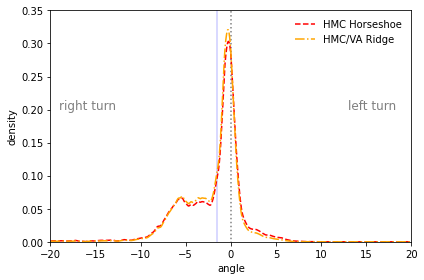

In [124]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec[12], color = 'red', linestyle= '--', label = 'HMC Horseshoe')
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_prec_horse[12], color = 'orange', label = 'HMC/VA Ridge', linestyle = '-.')
plt.xlabel('angle')
plt.ylabel('density')
plt.xlim(-20,20)
plt.ylim(0,0.35)
plt.text(-19, 0.2, 'right turn', size=12, color='grey')
plt.text(13, 0.2, 'left turn', size=12, color='grey')
plt.vlines(x = 0, ymin = -1, ymax = 1, linestyle = 'dotted', color = 'grey')
ax.legend()
plt.legend(framealpha=0.0)
plt.tight_layout()
plt.vlines(x = -1.5, ymin = -1, ymax = 1, color = 'blue', label = 'true steering angle', alpha = 0.2)
plt.savefig('../../data/commaai/calibration/examples_viz/dens_80_436run1.png') 

In [53]:
np.savetxt("density_ridge_va_precise_data_commaai_train_bags_2_121_254run1.csv", densities_va_prec[13], delimiter=",")

In [17]:
max(density['axes'])

50.42805947688219

# VA Ridge imprecise

In [ ]:
predictor_va_imprec = DensityPredictor('va_ridge', 'imprecise', 10)
predictor_va_imprec.load_bzeta_model()
predictor_va_imprec.predict_Bzeta(paths, True, False)
predictor_va_imprec.choose_method('va_ridge')
predictor_va_imprec.initialize_grid(density, 65536)
densities_va_imp = predictor_va_imprec.predict_density()

In [ ]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536),densities_va_imp[11])

In [ ]:
np.savetxt("density_ridge_va_imprecise_data_commaai_train_bags_2_0_118_977.png", densities_va_imp[11], delimiter=",")

# VA Horseshoe Precise

In [ ]:
predictor_va_horse_prec = DensityPredictor('va_horseshoe', 'precise', 10)
predictor_va_horse_prec.load_bzeta_model()
predictor_va_horse_prec.predict_Bzeta(paths, True, False)
predictor_va_horse_prec.choose_method('va_horseshoe')
predictor_va_horse_prec.initialize_grid(density, 65536)
densities_va_horse_prec = predictor_va_horse_prec.predict_density()

In [ ]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities_va_horse_prec[11])

In [ ]:
np.savetxt("density_horse_va_precise_data_commaai_train_bags_2_0_118_977.png", densities_va_horse_prec[11], delimiter=",")

In [ ]:
paths[11]

In [11]:
def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

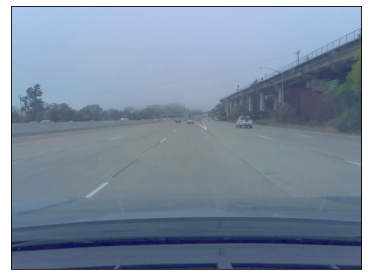

In [125]:
img = change_brightness(imageio.imread(paths[12]), value = 70)
img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../data/commaai/calibration/examples_viz/80_436run1.png', format='png', dpi=900)

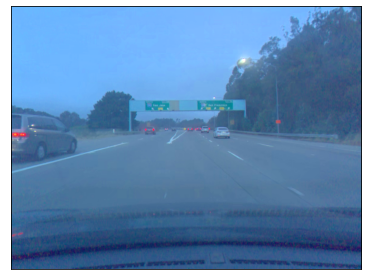

In [126]:
img = change_brightness(imageio.imread(paths[13]), value = 70)
img = cv2.resize(img, dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
figure, ax = plt.figure(), plt.gca()
ax.imshow(img[:,:,0:3])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.tight_layout()
figure.savefig('../../data/commaai/calibration/examples_viz/121_254run1.png', format='png', dpi=900)

In [ ]:
img = imageio.imread(paths[])
img_zoomed = cv2.resize(img[150:650,250:913,:], dsize = (291,218), interpolation = cv2.INTER_LINEAR)[76:142, 45:245,0:3]/255
plt.imshow(img_zoomed)

In [ ]:
img.shape

In [ ]:
1164/2 + 663.4799999999999/2

In [ ]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities[0])

In [ ]:
paths[12]

In [ ]:
np.savetxt("density_ridge_precise_data_commaai_train_bags_2_0_80_436run1.png", densities[12], delimiter=",")

In [ ]:
predictor = DensityPredictor('va_ridge', 'precise', 10)
#predictor.load_bzeta_model()
#predictor.predict_Bzeta(paths)
#predictor.choose_method('va_ridge')
#predictor.initialize_grid(density, 65536)
#densities = predictor.predict_density()
#predictor.load_z_model()
#z_pred = predictor.predict_z(paths)
#predictor.confidence_interval(density, confidence_level)
#predictor.show_predictive_density(0, 0, 0)

In [ ]:
predictor = DensityPredictor('va_ridge', 'precise', 10)
predictor.load_bzeta_model()
predictor.predict_Bzeta([0], False, img_zoomed.reshape(1,66,200,3))
predictor.choose_method('va_ridge')

In [ ]:
predictor.beta

In [ ]:
predictor.initialize_grid(density, 65536)

In [ ]:
densities = predictor.predict_density()

In [ ]:
predictor.load_bzeta_model()
predictor.predict_Bzeta(paths)
predictor.choose_method('va_horseshoe')

In [ ]:
predictor.initialize_grid(density, 65536)

In [ ]:
densities = predictor.predict_density()

In [ ]:
densities[1]

In [ ]:
densities = predictor.predict_density()

In [ ]:
predictor.show_predictive_density(0, 0, 0)

In [ ]:
plt.plot(np.linspace(min(density['axes']), max(density['axes']), 65536), densities[5])

In [ ]:
len(densities)

In [ ]:
conf_int = predictor.confidence_interval(density, 0.95, z_pred)

In [ ]:
true_y = [all_img_df.loc[all_img_df['path'] == path[32:], 'angle'] for path in paths]

In [ ]:
true_y

In [ ]:
all_img_df

In [ ]:
pred_y = [density.loc[find_closest_element(norm.cdf(z), density['cdf']), 'axes'] for z in z_pred]
conf_int_width = [conf_int_i[1] - conf_int_i[0] for conf_int_i in conf_int]

In [ ]:
plt.plot(np.array(abs(pred_y -true_y)), np.array(conf_int_width))

In [ ]:
true_y

In [ ]:
def loop_plot(plots):
    figs={}
    axs={}
    for idx,plot in enumerate(plots):
        figs[idx]=plt.figure()
        axs[idx]=figs[idx].add_subplot(111)
        axs[idx].plot(range(0,1000),plot)
    return figs, axs